### **Notebook to calculate biomass growth rate observations and predictions for Yoneda and Henson data**

### Data description:
#### Yoneda:
* WT 1.5g/L Phenol, 1.0g/L ammonium sulfate	 	(WT-R) ->**WT-HN-HP**
* Evol33 1.5g/L Phenol, 1.0g/L ammonium sulfate 	(EVOL33-R) ->**EVOL33-HN-HP**
* Evol40 1.5g/L Phenol, 1.0g/L ammonium sulfate 	(EVOL40-R) -> **EVOL40-HN-HP**
* WT 1.0g/L Glucose, 1.0g/L ammonium sulfate 		(WT-G) -> **WT-HN-G**
* Evol33 1.0g/L Glucose, 1.0g/L ammonium sulfate 	(EVOL33-G) -> **EVOL33-HN-G**
* Evol40 1.0g/L Glucose, 1.0g/L ammonium sulfate 	(EVOL40-G) -> **EVOL40-HN-G**
* WT 1.0g/L Glucose, 0.05g/L ammonium sulfate 	(WT-G-N) ->**WT-LN-G**
* Evol33 1.0g/L Glucose, 0.05g/L ammonium sulfate 	(EVOL33-G-N) ->**EVOL33-LN-G**
* Evol40 1.0g/L Glucose, 0.05g/L ammonium sulfate 	(EVOL40-G-N) ->**EVOL40-LN-G**
                                                 
#### Henson:
* WT 0.5g/L Phenol 		(WT-P-R) ->**WT-P**
* PVHG6 0.5g/L  Phenol 	(PVHG6-P-R) ->**PVHG-P**

In [1]:
#Python packages:
import numpy as np
import sys
import os
import pandas as pd
import cobra
import math
from scipy.stats import linregress
from scipy import mean

#### **Load Yoneda and Henson Data**

In [2]:
from edd_utils import login, export_study, export_metadata
# Study to Download
study_slug = 'biodesign_yoneda_set2'#multiomics-data-for-wt-strain-c157'
study_slug2 = 'biodesign_henson2108'
# EDD server
edd_server = 'public-edd.jbei.org'#agilebiofoundry.org'#'edd.jbei.org'
user       = 'schenkch'

In [3]:
session = login(edd_server=edd_server, user=user)

Password for schenkch:  ···············


In [4]:
#Export data from EDD as 2 dataframes:
df: pd.DataFrame

# filename = TBD
    
try:
    df = export_study(session, study_slug, edd_server=edd_server)
    df2 = export_study(session, study_slug2, edd_server=edd_server)
except (NameError, AttributeError, KeyError):
    try:
        df = pd.read_csv(filename)
    except:
        print(f'ERROR! Alternative loading of data from disk at {DISKDF} failed!')
    else:
        print(f'OK! Alternative loading of data from disk at {DISKDF} was successful.')


In [5]:
OD = df[df['Protocol'].str.contains('OD600')]#pd.read_csv(ODfile)
Sub = df[df['Protocol'].str.contains('HPLC')]

print(f'substrate data has {len(Sub)} lines')
print(f'OD data has {len(OD)} lines')

substrate data has 72 lines
OD data has 63 lines


In [6]:
ODHen = df2[df2['Protocol'].str.contains('OD600')]#pd.read_csv(ODfile)
SubHen = df2[df2['Protocol'].str.contains('HPLC')]

print(f'substrate data has {len(SubHen)} lines')
print(f'OD data has {len(ODHen)} lines')

substrate data has 48 lines
OD data has 60 lines


In [7]:
GRAMS_BIOMASS_PER_LITER_PER_OD = 0.368 # 1 OD = 0.368 g/L of biomass

In [8]:
#Predictions:
def calcquantities(ODdata, Subdata, molar_mass, max_time=0):
    if max_time != 0:
        ODdata = ODdata[ODdata['Hours'] < max_time]
        Subdata = Subdata[Subdata['Hours'] < max_time]
#     for ind in Subdata.index:
#         #if data point shows increase instead of decrease linearly interpolate from other data points
#         if ind!=Subdata.index[-1] and ind!=Subdata.index[-1]-1 and Subdata.loc[ind+1, 'Value']>Subdata.loc[ind, 'Value'] and Subdata.loc[ind+2, 'Value']<Subdata.loc[ind, 'Value']:
#             display('Subdata', Subdata)
#             #Subdata.loc[ind+1, 'Value'] = Subdata.loc[ind, 'Value'] + (Subdata.loc[ind+1, 'Hours']-Subdata.loc[ind, 'Hours'])*(Subdata.loc[ind+2, 'Value']-Subdata.loc[ind, 'Value'])/(Subdata.loc[ind+2, 'Hours']-Subdata.loc[ind, 'Hours'])
#         #if 2 data points in a row show increase instead of decrease set both to 0
#         elif ind!=Subdata.index[-1] and ind!=Subdata.index[-1]-1 and Subdata.loc[ind+1, 'Value']>Subdata.loc[ind, 'Value'] and Subdata.loc[ind+2, 'Value']>Subdata.loc[ind, 'Value']:
#             Subdata.loc[ind+1, 'Value'] = 0.0
#             Subdata.loc[ind+2, 'Value'] = 0.0
            
#growth is the slope of log(biomass) vs. time
#     ODdata=WTR1OD
#     Subdata=WTR1Sub
    #display(ODdata['Hours'])
    inittime=ODdata['Hours'].idxmin()#calculate index of initial time in dataframe
    growth_rate, _, _, _, _ = linregress(ODdata['Hours'].to_numpy(), [math.log(val) for val in ODdata['Biomass Conc'].to_numpy()])
    initindex = inittime

    # biomass X = X0*e^(μ*t)
    biomass_sim = [ODdata.at[inittime,'Biomass Conc']*math.exp(growth_rate*time) for time in ODdata['Hours']]
    #display(biomass_sim)

    # actual consumption = S0 - S
    inittimesub = Subdata[['Hours']].idxmin()#calculate index of initial time in dataframe
    initindexsub = inittimesub.values[0]
    #display(initindex)
    timestartsub = Subdata.loc[inittimesub+1, 'Hours']
    #display(timestartsub)
    sub_consumed = [Subdata.loc[inittimesub,'Value'].values[0]*1000/molar_mass - sub_value for sub_value in Subdata['Value'].to_numpy()*1000/molar_mass]
    #display(sub_consumed)
    
    # new biomass X = X0 - X
    biomass_sim_growth = [sim_val - ODdata.loc[inittime,'Biomass Conc'] for sim_val in biomass_sim]
    #display(biomass_sim_growth)
    # yield is the amount of biomass that can be made from a mmol of substrate
    yield_coeff, _, _, _, _ = linregress(sub_consumed, biomass_sim_growth[0:len(sub_consumed)])#this should be done differently!!!!
    # S = S0 - (1/yield)*X
    print('YC', yield_coeff)
    substrate_sim = [Subdata.loc[inittimesub,'Value'] - 1/yield_coeff*val for val in biomass_sim_growth]
    
    # units work out to mmol substrate consumed / (g biomass * hr)
    substrate_consumption_rate = (1/yield_coeff) * growth_rate
    print('Sub', substrate_consumption_rate)
    
    total_time = ODdata['Hours'][ODdata.index[-1]] - ODdata.loc[initindex,'Hours']
    times = ODdata['Hours'].to_numpy()

    return growth_rate, yield_coeff, substrate_consumption_rate, total_time, times

#### **Yoneda WT with 1.5g/L Phenol**

In [9]:
strindlist = ['WT-R1', 'WT-R2', 'WT-R3']# ['WT-HN-HP-R1', 'WT-HN-HP-R2', 'WT-HN-HP-R3']

In [10]:
for i in strindlist:
    if i=='WT-R1':#'WT-HN-HP-R1':
        WTR1OD = OD[OD['Line Name'].str.contains(str(i))]#pd.read_csv(ODfile)
        WTR1Sub = Sub[Sub['Line Name'].str.contains(str(i))]#pd.read_csv(ODfile)
        #newvals = GRAMS_BIOMASS_PER_LITER_PER_OD*WTR1OD.loc['Value'].to_numpy()
        WTR1OD.loc[:,'Biomass Conc'] = GRAMS_BIOMASS_PER_LITER_PER_OD*WTR1OD.loc[:,'Value']#newvals
    if i=='WT-R2':#'WT-HN-HP-R2':
        WTR2OD = OD[OD['Line Name'].str.contains(str(i))]#pd.read_csv(ODfile)
        WTR2Sub = Sub[Sub['Line Name'].str.contains(str(i))]#pd.read_csv(ODfile)
        #newvals = GRAMS_BIOMASS_PER_LITER_PER_OD*WTR1OD.loc['Value'].to_numpy()
        WTR2OD.loc[:,'Biomass Conc'] = GRAMS_BIOMASS_PER_LITER_PER_OD*WTR2OD.loc[:,'Value']#newvals
    if i=='WT-R3':#'WT-HN-HP-R3':
        WTR3OD = OD[OD['Line Name'].str.contains(str(i))]#pd.read_csv(ODfile)
        WTR3Sub = Sub[Sub['Line Name'].str.contains(str(i))]#pd.read_csv(ODfile)
        #newvals = GRAMS_BIOMASS_PER_LITER_PER_OD*WTR1OD.loc['Value'].to_numpy()
        WTR3OD.loc[:,'Biomass Conc'] = GRAMS_BIOMASS_PER_LITER_PER_OD*WTR3OD.loc[:,'Value']#newvals

/usr/local/share/jupyteruser/.pyenv/versions/biod_3.7/lib/python3.7/site-packages/pandas/core/indexing.py:362 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/share/jupyteruser/.pyenv/versions/biod_3.7/lib/python3.7/site-packages/pandas/core/indexing.py:480 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
growth_rateWTR1, yield_coeffWTR1, substrate_consumption_rateWTR1, total_timeWTR1, timesWTR1 = calcquantities(WTR1OD, WTR1Sub, molar_mass=94.11)
growth_rateWTR2, yield_coeffWTR2, substrate_consumption_rateWTR2, total_timeWTR2, timesWTR2 = calcquantities(WTR2OD, WTR2Sub, molar_mass=94.11)
growth_rateWTR3, yield_coeffWTR3, substrate_consumption_rateWTR3, total_timeWTR3, timesWTR3 = calcquantities(WTR3OD, WTR3Sub, molar_mass=94.11)

YC 0.027827318038384764
Sub 0.6710108805808497
YC 0.024876645223976222
Sub 0.7050026931406864
YC 0.032157638171491094
Sub 0.6285659287272015


##### **Create dataframe and add results**

In [12]:
#create dataframe for all results:
indlist = ['growth_rate', 'yield_coeff', 'substrate_consumption_rate', 'growth_rate_std', 'yield_coeff_std', 'substr_cons_rate_std', 'substrate_consumption_rate_R1', 'substrate_consumption_rate_R2', 'substrate_consumption_rate_R3']
strainslist = ['WT-R', 'EVOL33-R', 'EVOL40-R', 'WT-G', 'EVOL33-G', 'EVOL40-G', 'WT-G-N', 'EVOL33-G-N', 'EVOL40-G-N', 'WT-P-R', 'PVHG6-P-R']
growthandsubstrdata = pd.DataFrame(index=strainslist, columns=indlist, dtype=float)
growthandsubstrdata.at['WT-R',:]=[np.average([growth_rateWTR1,growth_rateWTR2,growth_rateWTR3]), np.average([yield_coeffWTR1,yield_coeffWTR2, yield_coeffWTR3]), np.average([substrate_consumption_rateWTR1, substrate_consumption_rateWTR2, substrate_consumption_rateWTR3]), np.std([growth_rateWTR1,growth_rateWTR2,growth_rateWTR3]), np.std([yield_coeffWTR1,yield_coeffWTR2, yield_coeffWTR3]), np.std([substrate_consumption_rateWTR1, substrate_consumption_rateWTR2, substrate_consumption_rateWTR3]), substrate_consumption_rateWTR1, substrate_consumption_rateWTR2, substrate_consumption_rateWTR3]
display(growthandsubstrdata)

,growth_rate,yield_coeff,substrate_consumption_rate,growth_rate_std,yield_coeff_std,substr_cons_rate_std,substrate_consumption_rate_R1,substrate_consumption_rate_R2,substrate_consumption_rate_R3
WT-R,0.018808,0.028287,0.668193,0.001096,0.00299,0.031269,0.671011,0.705003,0.628566
EVOL33-R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EVOL40-R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WT-G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EVOL33-G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EVOL40-G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WT-G-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EVOL33-G-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EVOL40-G-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WT-P-R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### **Yoneda Evol33 with 1.5g/L Phenol**

In [13]:
strindlist = ['EVOL33-R1', 'EVOL33-R2', 'EVOL33-R3']

In [14]:
for i in strindlist:
    if i=='EVOL33-R1':
        EVOL33R1OD = OD[OD['Line Name'].str.contains(str(i))]#pd.read_csv(ODfile)
        EVOL33R1Sub = Sub[Sub['Line Name'].str.contains(str(i))]#pd.read_csv(ODfile)
        #newvals = GRAMS_BIOMASS_PER_LITER_PER_OD*EVOL33R1OD.loc['Value'].to_numpy()
        EVOL33R1OD.loc[:,'Biomass Conc'] = GRAMS_BIOMASS_PER_LITER_PER_OD*EVOL33R1OD.loc[:,'Value']#newvals
    if i=='EVOL33-R2':
        EVOL33R2OD = OD[OD['Line Name'].str.contains(str(i))]#pd.read_csv(ODfile)
        EVOL33R2Sub = Sub[Sub['Line Name'].str.contains(str(i))]#pd.read_csv(ODfile)
        #newvals = GRAMS_BIOMASS_PER_LITER_PER_OD*EVOL33R1OD.loc['Value'].to_numpy()
        EVOL33R2OD.loc[:,'Biomass Conc'] = GRAMS_BIOMASS_PER_LITER_PER_OD*EVOL33R2OD.loc[:,'Value']#newvals
    if i=='EVOL33-R3':
        EVOL33R3OD = OD[OD['Line Name'].str.contains(str(i))]#pd.read_csv(ODfile)
        EVOL33R3Sub = Sub[Sub['Line Name'].str.contains(str(i))]#pd.read_csv(ODfile)
        #newvals = GRAMS_BIOMASS_PER_LITER_PER_OD*EVOL33R1OD.loc['Value'].to_numpy()
        EVOL33R3OD.loc[:,'Biomass Conc'] = GRAMS_BIOMASS_PER_LITER_PER_OD*EVOL33R3OD.loc[:,'Value']#newvals

In [15]:
growth_rateEVOL33R1, yield_coeffEVOL33R1, substrate_consumption_rateEVOL33R1, total_timeEVOL33R1, timesEVOL33R1 = calcquantities(EVOL33R1OD, EVOL33R1Sub, molar_mass=94.11, max_time=60)
growth_rateEVOL33R2, yield_coeffEVOL33R2, substrate_consumption_rateEVOL33R2, total_timeEVOL33R2, timesEVOL33R2 = calcquantities(EVOL33R2OD, EVOL33R2Sub, molar_mass=94.11, max_time=60)
growth_rateEVOL33R3, yield_coeffEVOL33R3, substrate_consumption_rateEVOL33R3, total_timeEVOL33R3, timesEVOL33R3 = calcquantities(EVOL33R3OD, EVOL33R3Sub, molar_mass=94.11, max_time=60)

YC 0.03183210037182815
Sub 0.9927916209724028
YC 0.03761486001568995
Sub 0.9523038341176187
YC 0.03506192376890004
Sub 0.9473521312309033


In [16]:
growth_rateEVOL33R1, yield_coeffEVOL33R1, substrate_consumption_rateEVOL33R1, total_timeEVOL33R1, timesEVOL33R1  

(0.03160264252710349,
 0.03183210037182815,
 0.9927916209724028,
 52.08611,
 array([ 0.     , 16.61361, 41.23694, 52.08611]))

In [17]:
growth_rateEVOL33R2, yield_coeffEVOL33R2, substrate_consumption_rateEVOL33R2, total_timeEVOL33R2, timesEVOL33R2 

(0.03582077541273905,
 0.03761486001568995,
 0.9523038341176187,
 52.08611,
 array([ 0.     , 16.61361, 41.23694, 52.08611]))

In [18]:
growth_rateEVOL33R3, yield_coeffEVOL33R3, substrate_consumption_rateEVOL33R3, total_timeEVOL33R3, timesEVOL33R3

(0.033215988207522924,
 0.03506192376890004,
 0.9473521312309033,
 52.08611,
 array([ 0.     , 16.61361, 41.23694, 52.08611]))

##### **Add results to dataframe**

In [19]:
#create dataframe for all results:
#indlist = ['growth_rate', 'yield_coeff', 'substrate_consumption_rate', 'growth_rate_std']
#strainslist = ['WT-R', 'EVOL33-R', 'EVOL40-R', 'WT-G', 'EVOL33-G', 'EVOL40-G', 'WT-G-N', 'EVOL33-G-N', 'EVOL40-G-N', 'WT-P-R', 'PVHG6-P-R']
#growthandsubstrdata = pd.DataFrame(index=strainslist, columns=indlist)
growthandsubstrdata.at['EVOL33-R',:]=[np.average([growth_rateEVOL33R1,growth_rateEVOL33R2,growth_rateEVOL33R3]), np.average([yield_coeffEVOL33R1,yield_coeffEVOL33R2, yield_coeffEVOL33R3]), np.average([substrate_consumption_rateEVOL33R1, substrate_consumption_rateEVOL33R2, substrate_consumption_rateEVOL33R3]),np.std([growth_rateEVOL33R1,growth_rateEVOL33R2,growth_rateEVOL33R3]), np.std([yield_coeffEVOL33R1,yield_coeffEVOL33R2, yield_coeffEVOL33R3]), np.std([substrate_consumption_rateEVOL33R1, substrate_consumption_rateEVOL33R2, substrate_consumption_rateEVOL33R3]),substrate_consumption_rateEVOL33R1, substrate_consumption_rateEVOL33R2, substrate_consumption_rateEVOL33R3]
display(growthandsubstrdata)

,growth_rate,yield_coeff,substrate_consumption_rate,growth_rate_std,yield_coeff_std,substr_cons_rate_std,substrate_consumption_rate_R1,substrate_consumption_rate_R2,substrate_consumption_rate_R3
WT-R,0.018808,0.028287,0.668193,0.001096,0.002990,0.031269,0.671011,0.705003,0.628566
EVOL33-R,0.033546,0.034836,0.964149,0.001738,0.002366,0.020354,0.992792,0.952304,0.947352
EVOL40-R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WT-G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EVOL33-G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EVOL40-G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WT-G-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EVOL33-G-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EVOL40-G-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WT-P-R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### **Yoneda Evol40 with 1.5g/L Phenol**

In [20]:
strindlist = ['EVOL40-R1', 'EVOL40-R2', 'EVOL40-R3']

In [21]:
for i in strindlist:
    if i=='EVOL40-R1':
        EVOL40R1OD = OD[OD['Line Name'].str.contains(str(i))]#pd.read_csv(ODfile)
        EVOL40R1Sub = Sub[Sub['Line Name'].str.contains(str(i))]#pd.read_csv(ODfile)
        #newvals = GRAMS_BIOMASS_PER_LITER_PER_OD*EVOL40R1OD.loc['Value'].to_numpy()
        EVOL40R1OD.loc[:,'Biomass Conc'] = GRAMS_BIOMASS_PER_LITER_PER_OD*EVOL40R1OD.loc[:,'Value']#newvals
    if i=='EVOL40-R2':
        EVOL40R2OD = OD[OD['Line Name'].str.contains(str(i))]#pd.read_csv(ODfile)
        EVOL40R2Sub = Sub[Sub['Line Name'].str.contains(str(i))]#pd.read_csv(ODfile)
        #newvals = GRAMS_BIOMASS_PER_LITER_PER_OD*EVOL40R1OD.loc['Value'].to_numpy()
        EVOL40R2OD.loc[:,'Biomass Conc'] = GRAMS_BIOMASS_PER_LITER_PER_OD*EVOL40R2OD.loc[:,'Value']#newvals
    if i=='EVOL40-R3':
        EVOL40R3OD = OD[OD['Line Name'].str.contains(str(i))]#pd.read_csv(ODfile)
        EVOL40R3Sub = Sub[Sub['Line Name'].str.contains(str(i))]#pd.read_csv(ODfile)
        #newvals = GRAMS_BIOMASS_PER_LITER_PER_OD*EVOL40R1OD.loc['Value'].to_numpy()
        EVOL40R3OD.loc[:,'Biomass Conc'] = GRAMS_BIOMASS_PER_LITER_PER_OD*EVOL40R3OD.loc[:,'Value']#newvals

In [22]:
growth_rateEVOL40R1, yield_coeffEVOL40R1, substrate_consumption_rateEVOL40R1, total_timeEVOL40R1, timesEVOL40R1 = calcquantities(EVOL40R1OD, EVOL40R1Sub, molar_mass=94.11, max_time=60)
growth_rateEVOL40R2, yield_coeffEVOL40R2, substrate_consumption_rateEVOL40R2, total_timeEVOL40R2, timesEVOL40R2 = calcquantities(EVOL40R2OD, EVOL40R2Sub, molar_mass=94.11, max_time=60)
growth_rateEVOL40R3, yield_coeffEVOL40R3, substrate_consumption_rateEVOL40R3, total_timeEVOL40R3, timesEVOL40R3 = calcquantities(EVOL40R3OD, EVOL40R3Sub, molar_mass=94.11, max_time=60)

YC 0.03490469979551819
Sub 0.9289114772101265
YC 0.038467531448479794
Sub 0.902962068472739
YC 0.04088192588655003
Sub 0.8596787655539326


##### **Add results to dataframe**

In [23]:
#create dataframe for all results:
#indlist = ['growth_rate', 'yield_coeff', 'substrate_consumption_rate', 'growth_rate_std']
#strainslist = ['WT-R', 'EVOL40-R', 'EVOL40-R', 'WT-G', 'EVOL40-G', 'EVOL40-G', 'WT-G-N', 'EVOL33-G-N', 'EVOL40-G-N', 'WT-P-R', 'PVHG6-P-R']
#growthandsubstrdata = pd.DataFrame(index=strainslist, columns=indlist)
growthandsubstrdata.at['EVOL40-R',:]=[np.average([growth_rateEVOL40R1,growth_rateEVOL40R2,growth_rateEVOL40R3]), np.average([yield_coeffEVOL40R1,yield_coeffEVOL40R2, yield_coeffEVOL40R3]), np.average([substrate_consumption_rateEVOL40R1, substrate_consumption_rateEVOL40R2, substrate_consumption_rateEVOL40R3]), np.std([growth_rateEVOL40R1,growth_rateEVOL40R2,growth_rateEVOL40R3]), np.std([yield_coeffEVOL40R1,yield_coeffEVOL40R2, yield_coeffEVOL40R3]), np.std([substrate_consumption_rateEVOL40R1, substrate_consumption_rateEVOL40R2, substrate_consumption_rateEVOL40R3]), substrate_consumption_rateEVOL40R1, substrate_consumption_rateEVOL40R2, substrate_consumption_rateEVOL40R3]
display(growthandsubstrdata)

,growth_rate,yield_coeff,substrate_consumption_rate,growth_rate_std,yield_coeff_std,substr_cons_rate_std,substrate_consumption_rate_R1,substrate_consumption_rate_R2,substrate_consumption_rate_R3
WT-R,0.018808,0.028287,0.668193,0.001096,0.002990,0.031269,0.671011,0.705003,0.628566
EVOL33-R,0.033546,0.034836,0.964149,0.001738,0.002366,0.020354,0.992792,0.952304,0.947352
EVOL40-R,0.034101,0.038085,0.897184,0.001198,0.002455,0.028558,0.928911,0.902962,0.859679
WT-G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EVOL33-G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EVOL40-G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WT-G-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EVOL33-G-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EVOL40-G-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WT-P-R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### **Yoneda WT with 1.0g/L Glucose, 1.0 g/l Ammonium Sulfate**

In [24]:
WTGOD = OD[OD['Line Name']=='WT-G']#pd.read_csv(ODfile)
WTGSub = Sub[Sub['Line Name']=='WT-G']#pd.read_csv(ODfile)
#newvals = GRAMS_BIOMASS_PER_LITER_PER_OD*WTGOD.loc['Value'].to_numpy()
WTGOD.loc[:,'Biomass Conc'] = GRAMS_BIOMASS_PER_LITER_PER_OD*WTGOD.loc[:,'Value']#newvals

In [25]:
growth_rateWTG, yield_coeffWTG, substrate_consumption_rateWTG, total_timeWTG, timesWTG = calcquantities(WTGOD, WTGSub, molar_mass=180.16)

YC 1.2092167902833597
Sub 0.02605723782268901


##### **Add results to dataframe**

In [26]:
#create dataframe for all results:
#indlist = ['growth_rate', 'yield_coeff', 'substrate_consumption_rate', 'growth_rate_std']
#strainslist = ['WT-R', 'EVOL33-R', 'EVOL40-R', 'WT-G', 'EVOL33-G', 'EVOL40-G', 'WT-G-N', 'EVOL33-G-N', 'EVOL40-G-N', 'WT-P-R', 'PVHG6-P-R']
#growthandsubstrdata = pd.DataFrame(index=strainslist, columns=indlist)
growthandsubstrdata.at['WT-G',:]=[growth_rateWTG, yield_coeffWTG, substrate_consumption_rateWTG, 0.0, 0.0, 0.0, 'NaN', 'NaN', 'NaN']
display(growthandsubstrdata)

,growth_rate,yield_coeff,substrate_consumption_rate,growth_rate_std,yield_coeff_std,substr_cons_rate_std,substrate_consumption_rate_R1,substrate_consumption_rate_R2,substrate_consumption_rate_R3
WT-R,0.018808,0.028287,0.668193,0.001096,0.002990,0.031269,0.671011,0.705003,0.628566
EVOL33-R,0.033546,0.034836,0.964149,0.001738,0.002366,0.020354,0.992792,0.952304,0.947352
EVOL40-R,0.034101,0.038085,0.897184,0.001198,0.002455,0.028558,0.928911,0.902962,0.859679
WT-G,0.031509,1.209217,0.026057,0.000000,0.000000,0.000000,NaN,NaN,NaN
EVOL33-G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EVOL40-G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WT-G-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EVOL33-G-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EVOL40-G-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WT-P-R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### **Yoneda EVOL33 with 1.0g/L Glucose, 1.0 g/l Ammonium Sulfate**

In [27]:
EVOL33GOD = OD[OD['Line Name']=='EVOL33-G']#pd.read_csv(ODfile)
EVOL33GSub = Sub[Sub['Line Name']=='EVOL33-G']#pd.read_csv(ODfile)
#newvals = GRAMS_BIOMASS_PER_LITER_PER_OD*EVOL33GOD.loc['Value'].to_numpy()
EVOL33GOD.loc[:,'Biomass Conc'] = GRAMS_BIOMASS_PER_LITER_PER_OD*EVOL33GOD.loc[:,'Value']#newvals

In [28]:
growth_rateEVOL33G, yield_coeffEVOL33G, substrate_consumption_rateEVOL33G, total_timeEVOL33G, timesEVOL33G = calcquantities(EVOL33GOD, WTGSub, molar_mass=180.16)

YC 1.1832168895748088
Sub 0.026325331169341448


##### **Add results to dataframe**

In [29]:
#create dataframe for all results:
#indlist = ['growth_rate', 'yield_coeff', 'substrate_consumption_rate', 'growth_rate_std']
#strainslist = ['WT-R', 'EVOL33-R', 'EVOL40-R', 'WT-G', 'EVOL33-G', 'EVOL40-G', 'WT-G-N', 'EVOL33-G-N', 'EVOL40-G-N', 'WT-P-R', 'PVHG6-P-R']
#growthandsubstrdata = pd.DataFrame(index=strainslist, columns=indlist)
growthandsubstrdata.at['EVOL33-G',:]=[growth_rateEVOL33G, yield_coeffEVOL33G, substrate_consumption_rateEVOL33G, 0.0, 0.0, 0.0,  'NaN', 'NaN', 'NaN']
display(growthandsubstrdata)

,growth_rate,yield_coeff,substrate_consumption_rate,growth_rate_std,yield_coeff_std,substr_cons_rate_std,substrate_consumption_rate_R1,substrate_consumption_rate_R2,substrate_consumption_rate_R3
WT-R,0.018808,0.028287,0.668193,0.001096,0.002990,0.031269,0.671011,0.705003,0.628566
EVOL33-R,0.033546,0.034836,0.964149,0.001738,0.002366,0.020354,0.992792,0.952304,0.947352
EVOL40-R,0.034101,0.038085,0.897184,0.001198,0.002455,0.028558,0.928911,0.902962,0.859679
WT-G,0.031509,1.209217,0.026057,0.000000,0.000000,0.000000,NaN,NaN,NaN
EVOL33-G,0.031149,1.183217,0.026325,0.000000,0.000000,0.000000,NaN,NaN,NaN
EVOL40-G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WT-G-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EVOL33-G-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EVOL40-G-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WT-P-R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### **Yoneda EVOL40 with 1.0g/L Glucose, 1.0 g/l Ammonium Sulfate**

In [30]:
EVOL40GOD = OD[OD['Line Name']=='EVOL40-G']#pd.read_csv(ODfile)
EVOL40GSub = Sub[Sub['Line Name']=='EVOL40-G']#pd.read_csv(ODfile)
#newvals = GRAMS_BIOMASS_PER_LITER_PER_OD*EVOL40GOD.loc['Value'].to_numpy()
EVOL40GOD.loc[:,'Biomass Conc'] = GRAMS_BIOMASS_PER_LITER_PER_OD*EVOL40GOD.loc[:,'Value']#newvals

In [31]:
growth_rateEVOL40G, yield_coeffEVOL40G, substrate_consumption_rateEVOL40G, total_timeEVOL40G, timesEVOL40G = calcquantities(EVOL40GOD, EVOL40GSub, molar_mass=180.16)

YC -0.5257346324170699
Sub -0.059464757011802157


##### **Add results to dataframe**

In [32]:
#create dataframe for all results:
#indlist = ['growth_rate', 'yield_coeff', 'substrate_consumption_rate', 'growth_rate_std']
#strainslist = ['WT-R', 'EVOL33-R', 'EVOL40-R', 'WT-G', 'EVOL33-G', 'EVOL40-G', 'WT-G-N', 'EVOL40-G-N', 'EVOL40-G-N', 'WT-P-R', 'PVHG6-P-R']
#growthandsubstrdata = pd.DataFrame(index=strainslist, columns=indlist)
growthandsubstrdata.at['EVOL40-G',:]=[growth_rateEVOL40G, yield_coeffEVOL40G, substrate_consumption_rateEVOL40G, 0.0, 0.0, 0.0, 'NaN', 'NaN', 'NaN']
display(growthandsubstrdata)

,growth_rate,yield_coeff,substrate_consumption_rate,growth_rate_std,yield_coeff_std,substr_cons_rate_std,substrate_consumption_rate_R1,substrate_consumption_rate_R2,substrate_consumption_rate_R3
WT-R,0.018808,0.028287,0.668193,0.001096,0.002990,0.031269,0.671011,0.705003,0.628566
EVOL33-R,0.033546,0.034836,0.964149,0.001738,0.002366,0.020354,0.992792,0.952304,0.947352
EVOL40-R,0.034101,0.038085,0.897184,0.001198,0.002455,0.028558,0.928911,0.902962,0.859679
WT-G,0.031509,1.209217,0.026057,0.000000,0.000000,0.000000,NaN,NaN,NaN
EVOL33-G,0.031149,1.183217,0.026325,0.000000,0.000000,0.000000,NaN,NaN,NaN
EVOL40-G,0.031263,-0.525735,-0.059465,0.000000,0.000000,0.000000,NaN,NaN,NaN
WT-G-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EVOL33-G-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EVOL40-G-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WT-P-R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### **Yoneda WT with 1.0g/L Glucose, 0.05 g/l Ammonium Sulfate**

In [33]:
WTGNOD = OD[OD['Line Name'].str.contains('WT-G-N')]#pd.read_csv(ODfile)
WTGNSub = Sub[Sub['Line Name'].str.contains('WT-G-N')]#pd.read_csv(ODfile)
#newvals = GRAMS_BIOMASS_PER_LITER_PER_OD*WTGNOD.loc['Value'].to_numpy()
WTGNOD.loc[:,'Biomass Conc'] = GRAMS_BIOMASS_PER_LITER_PER_OD*WTGNOD.loc[:,'Value']#newvals

In [34]:
growth_rateWTGN, yield_coeffWTGN, substrate_consumption_rateWTGN, total_timeWTGN, timesWTGN = calcquantities(WTGNOD, WTGNSub, molar_mass=180.16)

YC 1.9281822253644023
Sub 0.020228504126781063


##### **Add results to dataframe**

In [35]:
#create dataframe for all results:
#indlist = ['growth_rate', 'yield_coeff', 'substrate_consumption_rate', 'growth_rate_std']
#strainslist = ['WT-R', 'EVOL33-R', 'EVOL40-R', 'WT-G', 'EVOL33-G', 'EVOL40-G', 'WT-G-N', 'EVOL33-G-N', 'EVOL40-G-N', 'WT-P-R', 'PVHG6-P-R']
#growthandsubstrdata = pd.DataFrame(index=strainslist, columns=indlist)
growthandsubstrdata.at['WT-G-N',:]=[growth_rateWTGN, yield_coeffWTGN, substrate_consumption_rateWTGN, 0.0, 0.0, 0.0,  'NaN', 'NaN', 'NaN']
display(growthandsubstrdata)

,growth_rate,yield_coeff,substrate_consumption_rate,growth_rate_std,yield_coeff_std,substr_cons_rate_std,substrate_consumption_rate_R1,substrate_consumption_rate_R2,substrate_consumption_rate_R3
WT-R,0.018808,0.028287,0.668193,0.001096,0.002990,0.031269,0.671011,0.705003,0.628566
EVOL33-R,0.033546,0.034836,0.964149,0.001738,0.002366,0.020354,0.992792,0.952304,0.947352
EVOL40-R,0.034101,0.038085,0.897184,0.001198,0.002455,0.028558,0.928911,0.902962,0.859679
WT-G,0.031509,1.209217,0.026057,0.000000,0.000000,0.000000,NaN,NaN,NaN
EVOL33-G,0.031149,1.183217,0.026325,0.000000,0.000000,0.000000,NaN,NaN,NaN
EVOL40-G,0.031263,-0.525735,-0.059465,0.000000,0.000000,0.000000,NaN,NaN,NaN
WT-G-N,0.039004,1.928182,0.020229,0.000000,0.000000,0.000000,NaN,NaN,NaN
EVOL33-G-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EVOL40-G-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WT-P-R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### **Yoneda EVOL33 with 1.0g/L Glucose, 0.05 g/l Ammonium Sulfate**

In [36]:
EVOL33GNOD = OD[OD['Line Name'].str.contains('EVOL33-G-N')]#pd.read_csv(ODfile)
EVOL33GNSub = Sub[Sub['Line Name'].str.contains('EVOL33-G-N')]#pd.read_csv(ODfile)
#newvals = GRAMS_BIOMASS_PER_LITER_PER_OD*EVOL33GNOD.loc['Value'].to_numpy()
EVOL33GNOD.loc[:,'Biomass Conc'] = GRAMS_BIOMASS_PER_LITER_PER_OD*EVOL33GNOD.loc[:,'Value']#newvals

In [37]:
growth_rateEVOL33GN, yield_coeffEVOL33GN, substrate_consumption_rateEVOL33GN, total_timeEVOL33GN, timesEVOL33GN = calcquantities(EVOL33GNOD, EVOL33GNSub, molar_mass=180.16)

YC 1.0577876589076527
Sub 0.030952776740702657


##### **Add results to dataframe**

In [38]:
#create dataframe for all results:
#indlist = ['growth_rate', 'yield_coeff', 'substrate_consumption_rate', 'growth_rate_std']
#strainslist = ['WT-R', 'EVOL33-R', 'EVOL40-R', 'WT-G', 'EVOL33-G', 'EVOL40-G', 'WT-G-N', 'EVOL33-G-N', 'EVOL40-G-N', 'WT-P-R', 'PVHG6-P-R']
#growthandsubstrdata = pd.DataFrame(index=strainslist, columns=indlist)
growthandsubstrdata.at['EVOL33-G-N',:]=[growth_rateEVOL33GN, yield_coeffEVOL33GN, substrate_consumption_rateEVOL33GN, 0.0, 0.0, 0.0, 'NaN', 'NaN', 'NaN']
display(growthandsubstrdata)

,growth_rate,yield_coeff,substrate_consumption_rate,growth_rate_std,yield_coeff_std,substr_cons_rate_std,substrate_consumption_rate_R1,substrate_consumption_rate_R2,substrate_consumption_rate_R3
WT-R,0.018808,0.028287,0.668193,0.001096,0.002990,0.031269,0.671011,0.705003,0.628566
EVOL33-R,0.033546,0.034836,0.964149,0.001738,0.002366,0.020354,0.992792,0.952304,0.947352
EVOL40-R,0.034101,0.038085,0.897184,0.001198,0.002455,0.028558,0.928911,0.902962,0.859679
WT-G,0.031509,1.209217,0.026057,0.000000,0.000000,0.000000,NaN,NaN,NaN
EVOL33-G,0.031149,1.183217,0.026325,0.000000,0.000000,0.000000,NaN,NaN,NaN
EVOL40-G,0.031263,-0.525735,-0.059465,0.000000,0.000000,0.000000,NaN,NaN,NaN
WT-G-N,0.039004,1.928182,0.020229,0.000000,0.000000,0.000000,NaN,NaN,NaN
EVOL33-G-N,0.032741,1.057788,0.030953,0.000000,0.000000,0.000000,NaN,NaN,NaN
EVOL40-G-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WT-P-R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### **Yoneda EVOL40 with 1.0g/L Glucose, 0.05 g/l Ammonium Sulfate**

In [39]:
EVOL40GNOD = OD[OD['Line Name'].str.contains('EVOL40-G-N')]#pd.read_csv(ODfile)
EVOL40GNSub = Sub[Sub['Line Name'].str.contains('EVOL40-G-N')]#pd.read_csv(ODfile)
#newvals = GRAMS_BIOMASS_PER_LITER_PER_OD*EVOL40GNOD.loc['Value'].to_numpy()
EVOL40GNOD.loc[:,'Biomass Conc'] = GRAMS_BIOMASS_PER_LITER_PER_OD*EVOL40GNOD.loc[:,'Value']#newvals

In [40]:
growth_rateEVOL40GN, yield_coeffEVOL40GN, substrate_consumption_rateEVOL40GN, total_timeEVOL40GN, timesEVOL40GN = calcquantities(EVOL40GNOD, EVOL40GNSub, molar_mass=180.16)

YC 2.133006254267917
Sub 0.016013118115174904


##### **Add results to dataframe**

In [41]:
#create dataframe for all results:
#indlist = ['growth_rate', 'yield_coeff', 'substrate_consumption_rate', 'growth_rate_std']
#strainslist = ['WT-R', 'EVOL33-R', 'EVOL40-R', 'WT-G', 'EVOL33-G', 'EVOL40-G', 'WT-G-N', 'EVOL33-G-N', 'EVOL40-G-N', 'WT-P-R', 'PVHG6-P-R']
#growthandsubstrdata = pd.DataFrame(index=strainslist, columns=indlist)
growthandsubstrdata.at['EVOL40-G-N',:]=[growth_rateEVOL40GN, yield_coeffEVOL40GN, substrate_consumption_rateEVOL40GN,  0.0, 0.0, 0.0,  'NaN', 'NaN', 'NaN']
display(growthandsubstrdata)

,growth_rate,yield_coeff,substrate_consumption_rate,growth_rate_std,yield_coeff_std,substr_cons_rate_std,substrate_consumption_rate_R1,substrate_consumption_rate_R2,substrate_consumption_rate_R3
WT-R,0.018808,0.028287,0.668193,0.001096,0.002990,0.031269,0.671011,0.705003,0.628566
EVOL33-R,0.033546,0.034836,0.964149,0.001738,0.002366,0.020354,0.992792,0.952304,0.947352
EVOL40-R,0.034101,0.038085,0.897184,0.001198,0.002455,0.028558,0.928911,0.902962,0.859679
WT-G,0.031509,1.209217,0.026057,0.000000,0.000000,0.000000,NaN,NaN,NaN
EVOL33-G,0.031149,1.183217,0.026325,0.000000,0.000000,0.000000,NaN,NaN,NaN
EVOL40-G,0.031263,-0.525735,-0.059465,0.000000,0.000000,0.000000,NaN,NaN,NaN
WT-G-N,0.039004,1.928182,0.020229,0.000000,0.000000,0.000000,NaN,NaN,NaN
EVOL33-G-N,0.032741,1.057788,0.030953,0.000000,0.000000,0.000000,NaN,NaN,NaN
EVOL40-G-N,0.034156,2.133006,0.016013,0.000000,0.000000,0.000000,NaN,NaN,NaN
WT-P-R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
growthandsubstrdata.to_csv('growthandsubstratedata_glucose.csv', index=True, header= True)

#### **Henson WT with 0.5g/l Phenol**

In [43]:
strindlist = ['WT-P-R1', 'WT-P-R2', 'WT-P-R3']

In [44]:
for i in strindlist:
    if i=='WT-P-R1':
        WTPR1OD = ODHen[ODHen['Line Name'].str.contains(str(i))]#pd.read_csv(ODfile)
        WTPR1Sub = SubHen[SubHen['Line Name'].str.contains(str(i))]#pd.read_csv(ODfile)
        #newvals = GRAMS_BIOMASS_PER_LITER_PER_OD*WTPR1OD.loc['Value'].to_numpy()
        WTPR1OD.loc[:,'Biomass Conc'] = GRAMS_BIOMASS_PER_LITER_PER_OD*WTPR1OD.loc[:,'Value']#newvals
    if i=='WT-P-R2':
        WTPR2OD = ODHen[ODHen['Line Name'].str.contains(str(i))]#pd.read_csv(ODfile)
        WTPR2Sub = SubHen[SubHen['Line Name'].str.contains(str(i))]#pd.read_csv(ODfile)
        #newvals = GRAMS_BIOMASS_PER_LITER_PER_OD*WTPR1OD.loc['Value'].to_numpy()
        WTPR2OD.loc[:,'Biomass Conc'] = GRAMS_BIOMASS_PER_LITER_PER_OD*WTPR2OD.loc[:,'Value']#newvals
    if i=='WT-P-R3':
        WTPR3OD = ODHen[ODHen['Line Name'].str.contains(str(i))]#pd.read_csv(ODfile)
        WTPR3Sub = SubHen[SubHen['Line Name'].str.contains(str(i))]#pd.read_csv(ODfile)
        #newvals = GRAMS_BIOMASS_PER_LITER_PER_OD*WTPR1OD.loc['Value'].to_numpy()
        WTPR3OD.loc[:,'Biomass Conc'] = GRAMS_BIOMASS_PER_LITER_PER_OD*WTPR3OD.loc[:,'Value']#newvals

In [45]:
growth_rateWTPR1, yield_coeffWTPR1, substrate_consumption_rateWTPR1, total_timeWTPR1, timesWTPR1 = calcquantities(WTPR1OD, WTPR1Sub, molar_mass=94.11)#, max_time=40)
growth_rateWTPR2, yield_coeffWTPR2, substrate_consumption_rateWTPR2, total_timeWTPR2, timesWTPR2 = calcquantities(WTPR2OD, WTPR2Sub, molar_mass=94.11)#, max_time=40)
growth_rateWTPR3, yield_coeffWTPR3, substrate_consumption_rateWTPR3, total_timeWTPR3, timesWTPR3 = calcquantities(WTPR3OD, WTPR3Sub, molar_mass=94.11)#, max_time=40)

YC 0.011876866116438851
Sub 1.8165942877253125
YC 0.032219937001509186
Sub 1.6070231573739304
YC 0.025794501662175083
Sub 1.8600895743835884


##### **Add results to dataframe**

In [46]:
#create dataframe for all results:
#indlist = ['growth_rate', 'yield_coeff', 'substrate_consumption_rate', 'growth_rate_std']
#strainslist = ['WT-R', 'EVOL33-R', 'EVOL40-R', 'WT-G', 'EVOL33-G', 'EVOL40-G', 'WT-G-N', 'EVOL33-G-N', 'EVOL40-G-N', 'WT-P-R', 'PVHG6-P-R']
#growthandsubstrdata = pd.DataFrame(index=strainslist, columns=indlist)
growthandsubstrdata.at['WT-P-R',:]=[np.average([growth_rateWTPR1,growth_rateWTPR2,growth_rateWTPR3]), np.average([yield_coeffWTPR1,yield_coeffWTPR2, yield_coeffWTPR3]), np.average([substrate_consumption_rateWTPR1, substrate_consumption_rateWTPR2, substrate_consumption_rateWTPR3]), np.std([growth_rateWTPR1,growth_rateWTPR2,growth_rateWTPR3]), np.std([yield_coeffWTPR1,yield_coeffWTPR2, yield_coeffWTPR3]), np.std([substrate_consumption_rateWTPR1, substrate_consumption_rateWTPR2, substrate_consumption_rateWTPR3]), substrate_consumption_rateWTPR1, substrate_consumption_rateWTPR2, substrate_consumption_rateWTPR3]
display(growthandsubstrdata)

,growth_rate,yield_coeff,substrate_consumption_rate,growth_rate_std,yield_coeff_std,substr_cons_rate_std,substrate_consumption_rate_R1,substrate_consumption_rate_R2,substrate_consumption_rate_R3
WT-R,0.018808,0.028287,0.668193,0.001096,0.002990,0.031269,0.671011,0.705003,0.628566
EVOL33-R,0.033546,0.034836,0.964149,0.001738,0.002366,0.020354,0.992792,0.952304,0.947352
EVOL40-R,0.034101,0.038085,0.897184,0.001198,0.002455,0.028558,0.928911,0.902962,0.859679
WT-G,0.031509,1.209217,0.026057,0.000000,0.000000,0.000000,NaN,NaN,NaN
EVOL33-G,0.031149,1.183217,0.026325,0.000000,0.000000,0.000000,NaN,NaN,NaN
EVOL40-G,0.031263,-0.525735,-0.059465,0.000000,0.000000,0.000000,NaN,NaN,NaN
WT-G-N,0.039004,1.928182,0.020229,0.000000,0.000000,0.000000,NaN,NaN,NaN
EVOL33-G-N,0.032741,1.057788,0.030953,0.000000,0.000000,0.000000,NaN,NaN,NaN
EVOL40-G-N,0.034156,2.133006,0.016013,0.000000,0.000000,0.000000,NaN,NaN,NaN
WT-P-R,0.040445,0.023297,1.761236,0.013432,0.008491,0.110481,1.81659,1.60702,1.86009


#### **Henson PVHG6 with 0.5g/l Phenol**

In [47]:
strindlist = ['PVHG6-P-R1', 'PVHG6-P-R2', 'PVHG6-P-R3']

In [48]:
for i in strindlist:
    if i=='PVHG6-P-R1':
        PVHG6R1OD = ODHen[ODHen['Line Name'].str.contains(str(i))]#pd.read_csv(ODfile)
        PVHG6R1Sub = SubHen[SubHen['Line Name'].str.contains(str(i))]#pd.read_csv(ODfile)
        #newvals = GRAMS_BIOMASS_PER_LITER_PER_OD*PVHG6R1OD.loc['Value'].to_numpy()
        PVHG6R1OD.loc[:,'Biomass Conc'] = GRAMS_BIOMASS_PER_LITER_PER_OD*PVHG6R1OD.loc[:,'Value']#newvals
    if i=='PVHG6-P-R2':
        PVHG6R2OD = ODHen[ODHen['Line Name'].str.contains(str(i))]#pd.read_csv(ODfile)
        PVHG6R2Sub = SubHen[SubHen['Line Name'].str.contains(str(i))]#pd.read_csv(ODfile)
        #newvals = GRAMS_BIOMASS_PER_LITER_PER_OD*PVHG6R1OD.loc['Value'].to_numpy()
        PVHG6R2OD.loc[:,'Biomass Conc'] = GRAMS_BIOMASS_PER_LITER_PER_OD*PVHG6R2OD.loc[:,'Value']#newvals
    if i=='PVHG6-P-R3':
        PVHG6R3OD = ODHen[ODHen['Line Name'].str.contains(str(i))]#pd.read_csv(ODfile)
        PVHG6R3Sub = SubHen[SubHen['Line Name'].str.contains(str(i))]#pd.read_csv(ODfile)
        #newvals = GRAMS_BIOMASS_PER_LITER_PER_OD*PVHG6R1OD.loc['Value'].to_numpy()
        PVHG6R3OD.loc[:,'Biomass Conc'] = GRAMS_BIOMASS_PER_LITER_PER_OD*PVHG6R3OD.loc[:,'Value']#newvals

In [49]:
growth_ratePVHG6R1, yield_coeffPVHG6R1, substrate_consumption_ratePVHG6R1, total_timePVHG6R1, timesPVHG6R1 = calcquantities(PVHG6R1OD, PVHG6R1Sub, molar_mass=94.11)#, max_time=40)
growth_ratePVHG6R2, yield_coeffPVHG6R2, substrate_consumption_ratePVHG6R2, total_timePVHG6R2, timesPVHG6R2 = calcquantities(PVHG6R2OD, PVHG6R2Sub, molar_mass=94.11)#, max_time=40)
growth_ratePVHG6R3, yield_coeffPVHG6R3, substrate_consumption_ratePVHG6R3, total_timePVHG6R3, timesPVHG6R3 = calcquantities(PVHG6R3OD, PVHG6R3Sub, molar_mass=94.11)#, max_time=40)

YC 0.01235463630742676
Sub 2.2465691059502366
YC 0.02878055463989326
Sub 2.1787588195483405
YC 0.02782772382531321
Sub 2.2224170427259313


##### **Add results to dataframe**

In [50]:
#create dataframe for all results:
#indlist = ['growth_rate', 'yield_coeff', 'substrate_consumption_rate', 'growth_rate_std', 'yield_coeff_std', 'substr_cons_rate_std']
#strainslist = ['WT-R', 'EVOL33-R', 'EVOL40-R', 'WT-G', 'EVOL33-G', 'EVOL40-G', 'WT-G-N', 'EVOL33-G-N', 'EVOL40-G-N', 'WT-P-R', 'PVHG6-P-R']
#growthandsubstrdata = pd.DataFrame(index=strainslist, columns=indlist)
growthandsubstrdata.at['PVHG6-P-R',:]=[np.average([growth_ratePVHG6R1,growth_ratePVHG6R2,growth_ratePVHG6R3]), np.average([yield_coeffPVHG6R1,yield_coeffPVHG6R2, yield_coeffPVHG6R3]), np.average([substrate_consumption_ratePVHG6R1, substrate_consumption_ratePVHG6R2, substrate_consumption_ratePVHG6R3]), np.std([growth_ratePVHG6R1, growth_ratePVHG6R2, growth_ratePVHG6R3]), np.std([yield_coeffPVHG6R1,yield_coeffPVHG6R2, yield_coeffPVHG6R3]), np.std([substrate_consumption_ratePVHG6R1, substrate_consumption_ratePVHG6R2, substrate_consumption_ratePVHG6R3]), substrate_consumption_ratePVHG6R1, substrate_consumption_ratePVHG6R2, substrate_consumption_ratePVHG6R3]
display(growthandsubstrdata)

,growth_rate,yield_coeff,substrate_consumption_rate,growth_rate_std,yield_coeff_std,substr_cons_rate_std,substrate_consumption_rate_R1,substrate_consumption_rate_R2,substrate_consumption_rate_R3
WT-R,0.018808,0.028287,0.668193,0.001096,0.002990,0.031269,0.671011,0.705003,0.628566
EVOL33-R,0.033546,0.034836,0.964149,0.001738,0.002366,0.020354,0.992792,0.952304,0.947352
EVOL40-R,0.034101,0.038085,0.897184,0.001198,0.002455,0.028558,0.928911,0.902962,0.859679
WT-G,0.031509,1.209217,0.026057,0.000000,0.000000,0.000000,NaN,NaN,NaN
EVOL33-G,0.031149,1.183217,0.026325,0.000000,0.000000,0.000000,NaN,NaN,NaN
EVOL40-G,0.031263,-0.525735,-0.059465,0.000000,0.000000,0.000000,NaN,NaN,NaN
WT-G-N,0.039004,1.928182,0.020229,0.000000,0.000000,0.000000,NaN,NaN,NaN
EVOL33-G-N,0.032741,1.057788,0.030953,0.000000,0.000000,0.000000,NaN,NaN,NaN
EVOL40-G-N,0.034156,2.133006,0.016013,0.000000,0.000000,0.000000,NaN,NaN,NaN
WT-P-R,0.040445,0.023297,1.761236,0.013432,0.008491,0.110481,1.81659,1.60702,1.86009


#### **Getting and preparing the metabolic model**

In [51]:
file_name =  "../GSMs/Ropacus_annotated_curated_with_phenol_custom_biomass.xml"
model = cobra.io.read_sbml_model(file_name)

#### **Calculate growth rate prediction via FBA and pFBA**

In [52]:
growthandsubstrdata['FBA_growth_rate']=pd.Series(np.zeros(len(growthandsubstrdata['growth_rate'])), index=growthandsubstrdata.index)
growthandsubstrdata['pFBA_growth_rate']=pd.Series(np.zeros(len(growthandsubstrdata['growth_rate'])), index=growthandsubstrdata.index)
display(growthandsubstrdata)

,growth_rate,yield_coeff,substrate_consumption_rate,growth_rate_std,yield_coeff_std,substr_cons_rate_std,substrate_consumption_rate_R1,substrate_consumption_rate_R2,substrate_consumption_rate_R3,FBA_growth_rate,pFBA_growth_rate
WT-R,0.018808,0.028287,0.668193,0.001096,0.002990,0.031269,0.671011,0.705003,0.628566,0.0,0.0
EVOL33-R,0.033546,0.034836,0.964149,0.001738,0.002366,0.020354,0.992792,0.952304,0.947352,0.0,0.0
EVOL40-R,0.034101,0.038085,0.897184,0.001198,0.002455,0.028558,0.928911,0.902962,0.859679,0.0,0.0
WT-G,0.031509,1.209217,0.026057,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.0,0.0
EVOL33-G,0.031149,1.183217,0.026325,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.0,0.0
EVOL40-G,0.031263,-0.525735,-0.059465,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.0,0.0
WT-G-N,0.039004,1.928182,0.020229,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.0,0.0
EVOL33-G-N,0.032741,1.057788,0.030953,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.0,0.0
EVOL40-G-N,0.034156,2.133006,0.016013,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.0,0.0
WT-P-R,0.040445,0.023297,1.761236,0.013432,0.008491,0.110481,1.81659,1.60702,1.86009,0.0,0.0


In [53]:
growthandsubstrdata['FBA_growth_rate_std']=pd.Series(np.zeros(len(growthandsubstrdata['growth_rate'])), index=growthandsubstrdata.index)
growthandsubstrdata['pFBA_growth_rate_std']=pd.Series(np.zeros(len(growthandsubstrdata['growth_rate'])), index=growthandsubstrdata.index)
display(growthandsubstrdata)

,growth_rate,yield_coeff,substrate_consumption_rate,growth_rate_std,yield_coeff_std,substr_cons_rate_std,substrate_consumption_rate_R1,substrate_consumption_rate_R2,substrate_consumption_rate_R3,FBA_growth_rate,pFBA_growth_rate,FBA_growth_rate_std,pFBA_growth_rate_std
WT-R,0.018808,0.028287,0.668193,0.001096,0.002990,0.031269,0.671011,0.705003,0.628566,0.0,0.0,0.0,0.0
EVOL33-R,0.033546,0.034836,0.964149,0.001738,0.002366,0.020354,0.992792,0.952304,0.947352,0.0,0.0,0.0,0.0
EVOL40-R,0.034101,0.038085,0.897184,0.001198,0.002455,0.028558,0.928911,0.902962,0.859679,0.0,0.0,0.0,0.0
WT-G,0.031509,1.209217,0.026057,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.0,0.0,0.0,0.0
EVOL33-G,0.031149,1.183217,0.026325,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.0,0.0,0.0,0.0
EVOL40-G,0.031263,-0.525735,-0.059465,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.0,0.0,0.0,0.0
WT-G-N,0.039004,1.928182,0.020229,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.0,0.0,0.0,0.0
EVOL33-G-N,0.032741,1.057788,0.030953,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.0,0.0,0.0,0.0
EVOL40-G-N,0.034156,2.133006,0.016013,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.0,0.0,0.0,0.0
WT-P-R,0.040445,0.023297,1.761236,0.013432,0.008491,0.110481,1.81659,1.60702,1.86009,0.0,0.0,0.0,0.0


In [54]:
def scalegrowthtosub(solgrowth, soluptake, sub_uptake_2comp):
    factor = sub_uptake_2comp/(-soluptake)
    display(soluptake, sub_uptake_2comp, factor)
    display(factor)
    solgrowthnew = solgrowth*factor
    return solgrowthnew

In [55]:
for index in growthandsubstrdata.index:
    with model:
        medium = model.medium
        if '-G' in index:
            model.objective = 'Growth_Glucose'
            growth = 'Growth_Glucose'
            #model.objective = 'Growth'
            if growthandsubstrdata.loc[index,'substrate_consumption_rate_R1']!='NaN' and growthandsubstrdata.loc[index,'substrate_consumption_rate_R2']!='NaN' and growthandsubstrdata.loc[index,'substrate_consumption_rate_R3']!='NaN':
                #R1
                sub_uptake_rate1 = growthandsubstrdata.loc[index,'substrate_consumption_rate_R1']
                medium = {key:1000 for (key,value) in model.medium.items()}
                model.reactions.get_by_id('Growth_Phenol').upper_bound = 0.0
                model.reactions.get_by_id('Growth_Phenol').lower_bound = 0.0
                medium["EX_glc__D_e"] = sub_uptake_rate1
                medium["EX_phenol_e"] = 0.0
                model.reactions.get_by_id('EX_glc__D_e').upper_bound = -sub_uptake_rate1
                model.reactions.get_by_id('EX_glc__D_e').lower_bound = -sub_uptake_rate1
                model.reactions.get_by_id('EX_phenol_e').upper_bound = 0.0
                model.reactions.get_by_id('EX_phenol_e').lower_bound = 0.0
                model.medium = medium
        
                FBA_solution1 = model.optimize().objective_value
                try:
                    pFBA_solution1 = cobra.flux_analysis.pfba(model).fluxes[growth]
                except:
                    print('model for ' + index + ' is infeasible')
                    
                #R2
                sub_uptake_rate2= growthandsubstrdata.loc[index,'substrate_consumption_rate_R2']
                medium = {key:1000 for (key,value) in model.medium.items()}
                model.reactions.get_by_id('Growth_Phenol').upper_bound = 0.0
                model.reactions.get_by_id('Growth_Phenol').lower_bound = 0.0
                medium["EX_glc__D_e"] = sub_uptake_rate2
                medium["EX_phenol_e"] = 0.0
                model.reactions.get_by_id('EX_glc__D_e').upper_bound = -sub_uptake_rate2
                model.reactions.get_by_id('EX_glc__D_e').lower_bound = -sub_uptake_rate2
                model.reactions.get_by_id('EX_phenol_e').upper_bound = 0.0
                model.reactions.get_by_id('EX_phenol_e').lower_bound = 0.0
                model.medium = medium
        
                FBA_solution2 = model.optimize().objective_value
                try:
                    pFBA_solution2 = cobra.flux_analysis.pfba(model).fluxes[growth]
                except:
                    print('model for ' + index + ' is infeasible')
                #R3
                sub_uptake_rate3 = growthandsubstrdata.loc[index,'substrate_consumption_rate_R3']
                medium = {key:1000 for (key,value) in model.medium.items()}
                model.reactions.get_by_id('Growth_Phenol').upper_bound = 0.0
                model.reactions.get_by_id('Growth_Phenol').lower_bound = 0.0
                medium["EX_glc__D_e"] = sub_uptake_rate3
                medium["EX_phenol_e"] = 0.0
                model.reactions.get_by_id('EX_glc__D_e').upper_bound = -sub_uptake_rate3
                model.reactions.get_by_id('EX_glc__D_e').lower_bound = -sub_uptake_rate3
                model.reactions.get_by_id('EX_phenol_e').upper_bound = 0.0
                model.reactions.get_by_id('EX_phenol_e').lower_bound = 0.0
                model.medium = medium
        
                FBA_solution3 = model.optimize().objective_value
                try:
                    pFBA_solution3 = cobra.flux_analysis.pfba(model).fluxes[growth]
                except:
                    print('model for ' + index + ' is infeasible')
                growthandsubstrdata.loc[index,'FBA_growth_rate'] = np.average([FBA_solution1, FBA_solution2, FBA_solution3])#scaledgrowthrateFBA
                growthandsubstrdata.loc[index,'pFBA_growth_rate'] = np.average([pFBA_solution1, pFBA_solution2, pFBA_solution3])#scaledgrowthrateFBA
                growthandsubstrdata.loc[index,'FBA_growth_rate_std'] = np.std([FBA_solution1, FBA_solution2, FBA_solution3])
                growthandsubstrdata.loc[index,'pFBA_growth_rate_std'] = np.std([pFBA_solution1, pFBA_solution2, pFBA_solution3])
            else:
                sub_uptake_rate = growthandsubstrdata.loc[index,'substrate_consumption_rate']
                medium["EX_glc__D_e"] = sub_uptake_rate
                model.reactions.get_by_id('EX_glc__D_e').upper_bound = -sub_uptake_rate
                model.reactions.get_by_id('EX_glc__D_e').lower_bound = -sub_uptake_rate
                medium["EX_phenol_e"] = 0.0
                FBA_solution = model.optimize().objective_value
                try:
                    pFBA_solution = cobra.flux_analysis.pfba(model).fluxes[growth]
                except:
                    print('model for ' + index + ' is infeasible')
                growthandsubstrdata.loc[index,'FBA_growth_rate'] = FBA_solution#scaledgrowthrateFBA
                growthandsubstrdata.loc[index,'pFBA_growth_rate'] = pFBA_solution#scaledgrowthrateFBA
            #print(index)
        else:
            model.objective = 'Growth_Phenol'
            growth = 'Growth_Phenol' 
            if growthandsubstrdata.loc[index,'substrate_consumption_rate_R1']!='NaN' and growthandsubstrdata.loc[index,'substrate_consumption_rate_R2']!='NaN' and growthandsubstrdata.loc[index,'substrate_consumption_rate_R3']!='NaN':
                #R1
                sub_uptake_rate1 = growthandsubstrdata.loc[index,'substrate_consumption_rate_R1']
                medium = {key:1000 for (key,value) in model.medium.items()}
                model.reactions.get_by_id('Growth_Glucose').upper_bound = 0.0
                model.reactions.get_by_id('Growth_Glucose').lower_bound = 0.0
                medium["EX_glc__D_e"] = 0.0
                medium["EX_phenol_e"] = sub_uptake_rate1
                model.reactions.get_by_id('EX_phenol_e').upper_bound = -sub_uptake_rate1
                model.reactions.get_by_id('EX_phenol_e').lower_bound = -sub_uptake_rate1
                model.reactions.get_by_id('EX_glc__D_e').upper_bound = 0.0
                model.reactions.get_by_id('EX_glc__D_e').lower_bound = 0.0
                model.medium = medium
        
                FBA_solution1 = model.optimize().objective_value
                try:
                    pFBA_solution1 = cobra.flux_analysis.pfba(model).fluxes[growth]
                except:
                    print('model for ' + index + ' is infeasible')
                #R2
                sub_uptake_rate2 = growthandsubstrdata.loc[index,'substrate_consumption_rate_R2']
                medium = {key:1000 for (key,value) in model.medium.items()}
                model.reactions.get_by_id('Growth_Glucose').upper_bound = 0.0
                model.reactions.get_by_id('Growth_Glucose').lower_bound = 0.0
                medium["EX_glc__D_e"] = 0.0
                medium["EX_phenol_e"] = sub_uptake_rate2
                model.reactions.get_by_id('EX_phenol_e').upper_bound = -sub_uptake_rate2
                model.reactions.get_by_id('EX_phenol_e').lower_bound = -sub_uptake_rate2
                model.reactions.get_by_id('EX_glc__D_e').upper_bound = 0.0
                model.reactions.get_by_id('EX_glc__D_e').lower_bound = 0.0
                model.medium = medium
        
                FBA_solution2 = model.optimize().objective_value
                try:
                    pFBA_solution2 = cobra.flux_analysis.pfba(model).fluxes[growth]
                except:
                    print('model for ' + index + ' is infeasible')
                #R3
                sub_uptake_rate3 = growthandsubstrdata.loc[index,'substrate_consumption_rate_R3']
                medium = {key:1000 for (key,value) in model.medium.items()}
                model.reactions.get_by_id('Growth_Glucose').upper_bound = 0.0
                model.reactions.get_by_id('Growth_Glucose').lower_bound = 0.0
                medium["EX_glc__D_e"] = 0.0
                medium["EX_phenol_e"] = sub_uptake_rate3
                model.reactions.get_by_id('EX_phenol_e').upper_bound = -sub_uptake_rate3
                model.reactions.get_by_id('EX_phenol_e').lower_bound = -sub_uptake_rate3
                model.reactions.get_by_id('EX_glc__D_e').upper_bound = 0.0
                model.reactions.get_by_id('EX_glc__D_e').lower_bound = 0.0
                model.medium = medium
        
                FBA_solution3 = model.optimize().objective_value
                try:
                    pFBA_solution3 = cobra.flux_analysis.pfba(model).fluxes[growth]
                except:
                    print('model for ' + index + ' is infeasible')
                growthandsubstrdata.loc[index,'FBA_growth_rate'] = np.average([FBA_solution1, FBA_solution2, FBA_solution3])#scaledgrowthrateFBA
                growthandsubstrdata.loc[index,'pFBA_growth_rate'] = np.average([pFBA_solution1, pFBA_solution2, pFBA_solution3])#scaledgrowthrateFBA
                growthandsubstrdata.loc[index,'FBA_growth_rate_std'] = np.std([FBA_solution1, FBA_solution2, FBA_solution3])
                growthandsubstrdata.loc[index,'pFBA_growth_rate_std'] = np.std([pFBA_solution1, pFBA_solution2, pFBA_solution3])
            else: 
                sub_uptake_rate = growthandsubstrdata.loc[index,'substrate_consumption_rate']
                medium = {key:1000 for (key,value) in model.medium.items()}
                model.reactions.get_by_id('Growth_Glucose').upper_bound = 0.0
                model.reactions.get_by_id('Growth_Glucose').lower_bound = 0.0
                medium["EX_glc__D_e"] = 0.0
                medium["EX_phenol_e"] = sub_uptake_rate
                model.reactions.get_by_id('EX_phenol_e').upper_bound = -sub_uptake_rate
                model.reactions.get_by_id('EX_phenol_e').lower_bound = -sub_uptake_rate
                model.reactions.get_by_id('EX_glc__D_e').upper_bound = 0.0
                model.reactions.get_by_id('EX_glc__D_e').lower_bound = 0.0
        
                FBA_solution = model.optimize().objective_value
                try:
                    pFBA_solution = cobra.flux_analysis.pfba(model).fluxes[growth]
                except:
                    print('model for ' + index + ' is infeasible')
#                 growthandsubstrdata.loc[index,'FBA_growth_rate'] = FBA_solution#scaledgrowthrateFBA
#                 growthandsubstrdata.loc[index,'pFBA_growth_rate'] = pFBA_solution#scaledgrowthrateFBA




cobra/util/solver.py:416 UserWarning: solver status is 'infeasible'


model for EVOL40-G is infeasible


In [56]:
display(growthandsubstrdata)

,growth_rate,yield_coeff,substrate_consumption_rate,growth_rate_std,yield_coeff_std,substr_cons_rate_std,substrate_consumption_rate_R1,substrate_consumption_rate_R2,substrate_consumption_rate_R3,FBA_growth_rate,pFBA_growth_rate,FBA_growth_rate_std,pFBA_growth_rate_std
WT-R,0.018808,0.028287,0.668193,0.001096,0.002990,0.031269,0.671011,0.705003,0.628566,0.063811,0.063811,0.002986,0.002986
EVOL33-R,0.033546,0.034836,0.964149,0.001738,0.002366,0.020354,0.992792,0.952304,0.947352,0.092074,0.092074,0.001944,0.001944
EVOL40-R,0.034101,0.038085,0.897184,0.001198,0.002455,0.028558,0.928911,0.902962,0.859679,0.085679,0.085679,0.002727,0.002727
WT-G,0.031509,1.209217,0.026057,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.227566,0.227566,0.000000,0.000000
EVOL33-G,0.031149,1.183217,0.026325,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.227591,0.227591,0.000000,0.000000
EVOL40-G,0.031263,-0.525735,-0.059465,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.059465,0.227591,0.000000,0.000000
WT-G-N,0.039004,1.928182,0.020229,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.227030,0.227030,0.000000,0.000000
EVOL33-G-N,0.032741,1.057788,0.030953,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.228017,0.228017,0.000000,0.000000
EVOL40-G-N,0.034156,2.133006,0.016013,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.226643,0.226643,0.000000,0.000000
WT-P-R,0.040445,0.023297,1.761236,0.013432,0.008491,0.110481,1.81659,1.60702,1.86009,0.168193,0.168193,0.010551,0.010551


##### Update IDs as in paper draft

### Data description:
#### Yoneda:
* WT 1.5g/L Phenol, 1.0g/L ammonium sulfate	 	(WT-R) ->**WT-HN-HP**
* Evol33 1.5g/L Phenol, 1.0g/L ammonium sulfate 	(EVOL33-R) ->**EVOL33-HN-HP**
* Evol40 1.5g/L Phenol, 1.0g/L ammonium sulfate 	(EVOL40-R) -> **EVOL40-HN-HP**
* WT 1.0g/L Glucose, 1.0g/L ammonium sulfate 		(WT-G) -> **WT-HN-G**
* Evol33 1.0g/L Glucose, 1.0g/L ammonium sulfate 	(EVOL33-G) -> **EVOL33-HN-G**
* Evol40 1.0g/L Glucose, 1.0g/L ammonium sulfate 	(EVOL40-G) -> **EVOL40-HN-G**
* WT 1.0g/L Glucose, 0.05g/L ammonium sulfate 	(WT-G-N) ->**WT-LN-G**
* Evol33 1.0g/L Glucose, 0.05g/L ammonium sulfate 	(EVOL33-G-N) ->**EVOL33-LN-G**
* Evol40 1.0g/L Glucose, 0.05g/L ammonium sulfate 	(EVOL40-G-N) ->**EVOL40-LN-G**
                                                 
#### Henson:
* WT 0.5g/L Phenol 		(WT-P-R) ->**WT-P**
* PVHG6 0.5g/L  Phenol 	(PVHG6-P-R) ->**PVHG-P**

In [57]:
growthandsubstrdata_upd = growthandsubstrdata.copy()
new_index = ['WT-HN-HP','EVOL33-HN-HP', 'EVOL40-HN-HP', 'WT-HN-G', 'EVOL33-HN-G', 'EVOL40-HN-G',  'WT-LN-G', 'EVOL33-LN-G', 'EVOL40-LN-G', 'WT-P', 'PVHG-P'] 
growthandsubstrdata_upd.index = new_index

In [58]:
growthandsubstrdata_upd

,growth_rate,yield_coeff,substrate_consumption_rate,growth_rate_std,yield_coeff_std,substr_cons_rate_std,substrate_consumption_rate_R1,substrate_consumption_rate_R2,substrate_consumption_rate_R3,FBA_growth_rate,pFBA_growth_rate,FBA_growth_rate_std,pFBA_growth_rate_std
WT-HN-HP,0.018808,0.028287,0.668193,0.001096,0.002990,0.031269,0.671011,0.705003,0.628566,0.063811,0.063811,0.002986,0.002986
EVOL33-HN-HP,0.033546,0.034836,0.964149,0.001738,0.002366,0.020354,0.992792,0.952304,0.947352,0.092074,0.092074,0.001944,0.001944
EVOL40-HN-HP,0.034101,0.038085,0.897184,0.001198,0.002455,0.028558,0.928911,0.902962,0.859679,0.085679,0.085679,0.002727,0.002727
WT-HN-G,0.031509,1.209217,0.026057,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.227566,0.227566,0.000000,0.000000
EVOL33-HN-G,0.031149,1.183217,0.026325,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.227591,0.227591,0.000000,0.000000
EVOL40-HN-G,0.031263,-0.525735,-0.059465,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.059465,0.227591,0.000000,0.000000
WT-LN-G,0.039004,1.928182,0.020229,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.227030,0.227030,0.000000,0.000000
EVOL33-LN-G,0.032741,1.057788,0.030953,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.228017,0.228017,0.000000,0.000000
EVOL40-LN-G,0.034156,2.133006,0.016013,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.226643,0.226643,0.000000,0.000000
WT-P,0.040445,0.023297,1.761236,0.013432,0.008491,0.110481,1.81659,1.60702,1.86009,0.168193,0.168193,0.010551,0.010551


####  **Generate scatter plot to compare observed and predicted growth rates (FBA, pFBA)**

In [59]:
#Scatterplot of solutions
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy
from scipy.stats import linregress

def maefunc(y_predict, y_actual):
    """Mean Absolute Error.
    Multioutput case included."""

    if y_actual.ndim == 1:
        return np.mean(np.abs([y_a - y_p for y_a, y_p in zip(y_actual, y_predict)]))
    else:
        return [
            np.mean(
                np.abs([y_a - y_p for y_a, y_p in zip(y_actual[:, i], y_predict[:, i])])
            )
            for i in range(y_actual.shape[1])
        ]
    
def scatterplotcompare(observed, predicted, labels, strtitle):
    fig, ax = plt.subplots(figsize=(8, 8))
    #res = stats.linregress(observed.to_numpy().astype(float), predicted.to_numpy())
    #print(res.rvalue**2)
    lims = [
                np.min([observed, predicted]),  # min of both axes
                np.max([observed, predicted]),  # max of both axes
            ]
    ax.set_xlim(lims)
    #ax.plot([0.0, 0.5], [0.0, 0.5], 'k',  c='0.55')
    # Plot Diagonal Dashed Line
    ax.plot(lims, lims, ls="--", color=".8", zorder=0)
    for i in range(0, len(observed)):
        ax.scatter(observed[i], predicted[i])
        ax.annotate(str(labels[i]),(observed[i],predicted[i]))
    #ax.annotate("r-squared = {:.3f}".format(round(r2_score(observed, predicted))), (0, 1))
    #plt.plot(observed, res.intercept + res.slope*observed, 'k', label='fitted line')
    rss = np.sum((predicted - observed) ** 2)
    tss = np.sum((predicted - predicted.mean()) ** 2)
    display(tss)
    if tss>=1e-6:
        r2_1 = round(1 - rss / tss,2)
    else:
        r2_1 = round(1 - rss/tss,2)#####?????
    display(set(observed))
    display(type(observed))
    _, _, growth_r, _, _ = scipy.stats.linregress(observed, predicted)
    #display(r2_1)
    #r2 = round(r2_score(observed, predicted),2)
    mse = np.round(1/len(observed) * rss,2) 
    rmse = np.round(np.sqrt(1/len(observed) * rss),2)
    #display(rmse)
    #display(r2_score(observed, predicted))
    mae_score = round(maefunc(observed, predicted),2)
    plt.xlabel(r'Observed growth rates [$mmol/gDW/hr$]')
    plt.ylabel(r'Predicted growth rates [$mmol/gDW/hr$]')
    plt.title(r'Growth rates: Observed vs. Predicted ('+strtitle+'), \n' + f"$R^2$={growth_r**2:.2F}, MAE={mae_score}, MSE = {mse}, RMSE={rmse}", fontsize=18)
    plt.show()

0.054620401795075824

{0.01880791025442839,
 0.031148576463214953,
 0.031262682169370185,
 0.03150884948360217,
 0.03274146524523911,
 0.03354646871578849,
 0.034101140531335644,
 0.03415608108999895,
 0.039004242102969704,
 0.040444571883995854,
 0.05076874639544098}

pandas.core.series.Series

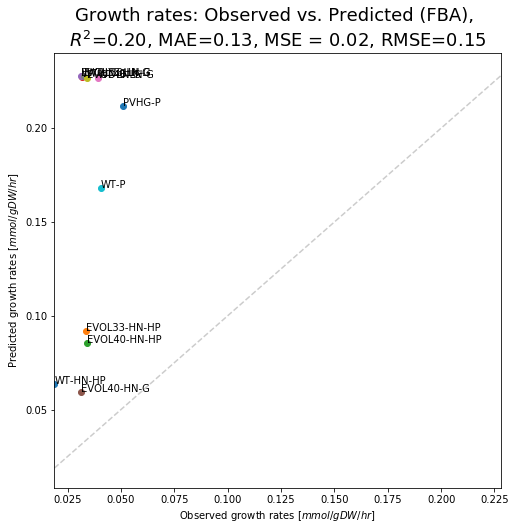

0.04474868315578643

{0.01880791025442839,
 0.031148576463214953,
 0.031262682169370185,
 0.03150884948360217,
 0.03274146524523911,
 0.03354646871578849,
 0.034101140531335644,
 0.03415608108999895,
 0.039004242102969704,
 0.040444571883995854,
 0.05076874639544098}

pandas.core.series.Series

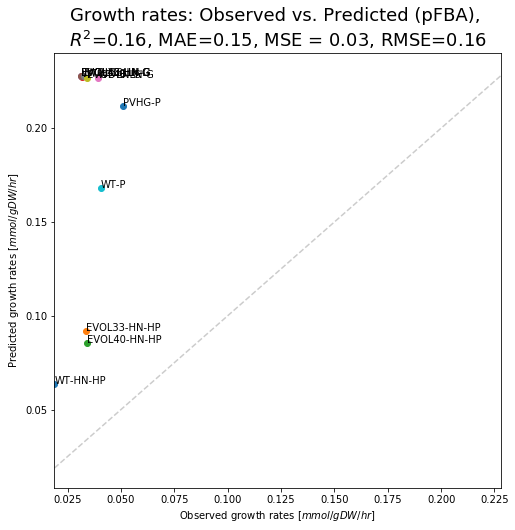

In [60]:
scatterplotcompare(growthandsubstrdata_upd['growth_rate'], growthandsubstrdata_upd['FBA_growth_rate'], growthandsubstrdata_upd.index, 'FBA')
scatterplotcompare(growthandsubstrdata_upd['growth_rate'], growthandsubstrdata_upd['pFBA_growth_rate'], growthandsubstrdata_upd.index, 'pFBA')

In [61]:
growthandsubstrdata_upd.to_csv('growthandsubstratedata.csv', index=True, header= True)